In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [22]:
df = pd.read_csv("./input/project/twitter_emotions.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [24]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [25]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [26]:
df['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [27]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text

In [28]:
df['cleaned_text'] = df['text'].apply(data_cleaning)

# Modeling

In [109]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
max_length = df['cleaned_text'].apply(lambda x: len(str(x).split())).max()

In [111]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

X_train.shape, X_test.shape

((333447, 79), (83362, 79))

In [112]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [114]:
GLOVE_EMB = './glove.6B/glove.6B.300d.txt'

embeddings_index = {}

f = open(GLOVE_EMB , encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

#embeddings_index['the']

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

Found 400000 word vectors.


In [116]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False)

In [118]:
max_length, 

(79, 79)

In [131]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras import Model

sequence_input = Input(shape=(X_train.shape[1],))
embedding_sequences = embedding_layer(sequence_input)

x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_sequences)
outputs = Dense(6, activation='softmax')(x)

model = Model(sequence_input, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 79)]              0         
                                                                 
 embedding (Embedding)       (None, 79, 300)           22545300  
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22732954 (86.72 MB)
Trainable params: 187654 (733.02 KB)
Non-trainable params: 22545300 (86.00 MB)
_________________________________________________________________


In [133]:
# Only ha
history = model.fit(X_train , y_train, validation_split=0.2, epochs=5)

Epoch 1/5
8337/8337 [==============================] - 1281s 153ms/step - loss: 0.2494 - accuracy: 0.8955 - val_loss: 0.1111 - val_accuracy: 0.9349
Epoch 2/5
8337/8337 [==============================] - 1089s 131ms/step - loss: 0.1165 - accuracy: 0.9348 - val_loss: 0.1004 - val_accuracy: 0.9368
Epoch 3/5
8337/8337 [==============================] - 5718s 686ms/step - loss: 0.1044 - accuracy: 0.9377 - val_loss: 0.0979 - val_accuracy: 0.9366
Epoch 4/5
8337/8337 [==============================] - 1207s 145ms/step - loss: 0.0994 - accuracy: 0.9398 - val_loss: 0.0980 - val_accuracy: 0.9371
Epoch 5/5
8337/8337 [==============================] - 1321s 158ms/step - loss: 0.0971 - accuracy: 0.9407 - val_loss: 0.0964 - val_accuracy: 0.9360


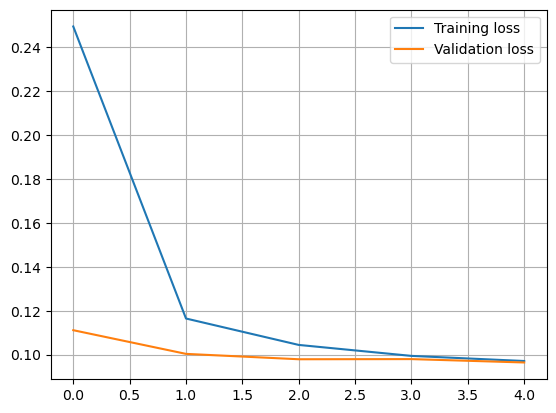

In [134]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.grid()
plt.show()

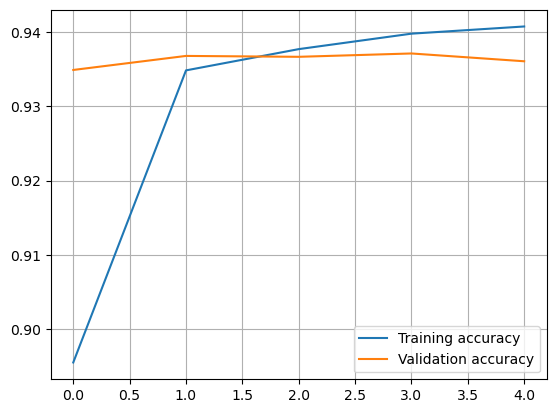

In [136]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")

plt.legend()
plt.grid()
plt.show()

In [137]:
predictions = model.predict(X_test)

2606/2606 [==============================] - 43s 16ms/step


Lets compare the first Ten true labels with their corresponding predicted labels.

In [139]:
y_pred = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0 0 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

0.9362299369017059


In [160]:
original_texts = []
for sequence in X_test:
    original_text = tokenizer.sequences_to_texts([sequence])[0]
    original_texts.append(original_text)

In [165]:
comparison_df = pd.DataFrame()
comparison_df['y_pred'] = y_pred
comparison_df['y_test'] = y_test

In [167]:
# print first 10 predicted and true labels to have a look
compare_dataframe[:10]

,y_pred,y_test
0,1,1
1,1,1
2,3,3
3,1,1
4,1,1
5,0,0
6,0,0
7,1,1
8,1,1
9,0,0


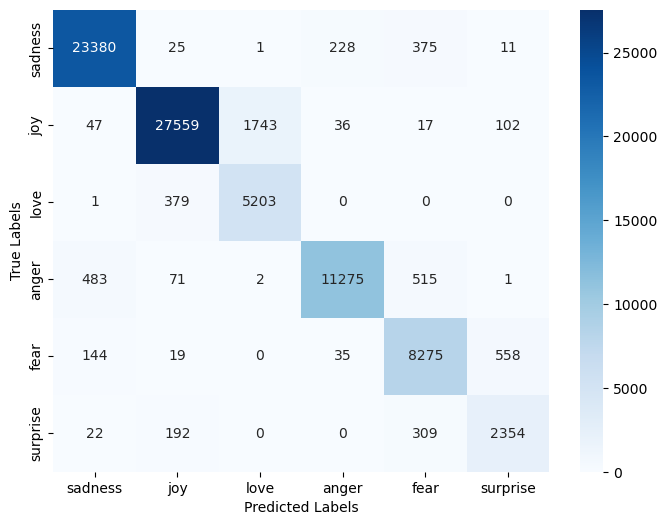

In [145]:
# # sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).
# class_labels = ['sadness', 'joy','love','anger','fear', 'surprise']

# conf_matrix = confusion_matrix(y_pred, y_test)

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()